# 수집된 데이터에 대한 통계 분석
* 데이터 
> 2017년 12월 1일부터 2018년 1월 1일까지 32일간 [네이버](http://www.naver.com)와 [다음](http://www.daum.net)의 랭킹뉴스와 뉴스의 댓글을 크롤링함.

In [1]:
import os
import pandas as pd 
from glob import glob
import sys
import time, re, pickle, itertools
import urllib3, json
sys.path.append('~/Documents/GitHub/Private_Project/personal_project/')
import re
from operator import itemgetter
import html
from collections import Counter
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import chat_bot as cb
import Database_Handler as dh
from datetime import datetime
import seaborn as sns
import functools
%matplotlib inline

In [2]:
#site = 'Naver'
site = 'daum'
if site == 'daum':
    binList = []
    collection = 'newsDaum'
elif site.lower() == 'naver':
    binList = []
    collection = 'newsNaver'

mongodb = dh.ToMongoDB(*dh.AWS_MongoDB_Information())
dbname = 'hy_db'
useDb = dh.Use_Database(mongodb, dbname)
useCollection = dh.Use_Collection(useDb, collection)
collection = useCollection.find({'site':site})

In [3]:
'''
dataDict = dict()
for data in collection:
    dataDict[data['_id']._ObjectId__id.hex()] = idData = dict()
    idData['category'] = data['category']
    idData['date'] = data['date']
    idData['press'] = data['press']
    idData['number_of_comment'] = data['number_of_comment']
    idData['number_of_crawled_comment'] = data['real_number_of_comment']
pickle.dump(dataDict, open('./data/pre_data/for_statistics_'+site+'_from_mongodb.pickled','wb'))
print (len(dataDict))
'''

"\ndataDict = dict()\nfor data in collection:\n    dataDict[data['_id']._ObjectId__id.hex()] = idData = dict()\n    idData['category'] = data['category']\n    idData['date'] = data['date']\n    idData['press'] = data['press']\n    idData['number_of_comment'] = data['number_of_comment']\n    idData['number_of_crawled_comment'] = data['real_number_of_comment']\npickle.dump(dataDict, open('./data/pre_data/for_statistics_'+site+'_from_mongodb.pickled','wb'))\nprint (len(dataDict))\n"

# 다음 (Daum)

In [4]:
file = './data/pre_data/for_statistics_daum_from_mongodb.pickled'
dataDict_daum = pickle.load(open(file,'rb'))

In [5]:
df_daum = pd.DataFrame.from_dict(dataDict_daum, orient='index')
df_daum['date'] = pd.to_datetime(df_daum['date']).dt.date
df_daum.reset_index(inplace = True)
df_daum.rename(columns={'index':'id'}, inplace=True)
print (df_daum.shape)
df_daum.head()

(4722, 6)


,id,category,date,press,number_of_comment,number_of_crawled_comment
0,5a2a61bf588c13481c229d1e,뉴스,2017-12-07,세계일보,1093,911
1,5a2a61bf588c13481c229d1f,뉴스,2017-12-07,헬스조선,603,386
2,5a2a61bf588c13481c229d20,뉴스,2017-12-07,연합뉴스,1067,811
3,5a2a61bf588c13481c229d21,뉴스,2017-12-07,헤럴드경제,418,369
4,5a2a61bf588c13481c229d22,뉴스,2017-12-07,연합뉴스,434,368


In [6]:
start = df_daum['date'].min()
end = df_daum['date'].max()
print ('수집된 날짜 : {} ~ {}, {}일간'.format(start.strftime('%Y-%m-%d'), end.strftime('%Y-%m-%d'), (end-start).days+1))
count = len(df_daum['press'].unique())
print ('number of news in naver : {} '.format(df_daum.shape[0]))
print ('다음 뉴스에 등록된 언론사의 수 : {}'.format(156))
print ('뉴스 기사가 한번이라도 네이버의 랭킹뉴스에 등록된 언론사의 수 : {}, 전체의 {:0.1f}%'.format(count, count/156*100))

수집된 날짜 : 2017-12-01 ~ 2018-01-01, 32일간
number of news in naver : 4722 
다음 뉴스에 등록된 언론사의 수 : 156
뉴스 기사가 한번이라도 네이버의 랭킹뉴스에 등록된 언론사의 수 : 96, 전체의 61.5%


### DAUM 뉴스에 등록된 언론사 목록
![사진](./daum_news.png )

In [7]:
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
web = 'http://media.daum.net/cp/'
res = requests.get(web)
soup = BeautifulSoup(res.content, 'html.parser')
x1 = soup.find('div',class_='box_etc')
x2 = x1.find_all('div', class_='item_cp')

pressdict = dict()
count = 0 
for i in x2:
    key = i.find('h4').text
    values = i.find_all('li')
    count += len(values)
    values = list(map(lambda x: x.text.strip(), values))
    pressdict[key] = values
print (count)

156


In [8]:
enrolledPress = list()
for idx in pressdict:
    enrolledPress.append((idx.strip(), len(pressdict[idx])))
enrolledPress = pd.DataFrame(enrolledPress)
enrolledPress.rename(columns={0:'category',1:'count'},inplace = True)
enrolledPress.set_index('category', inplace = True)

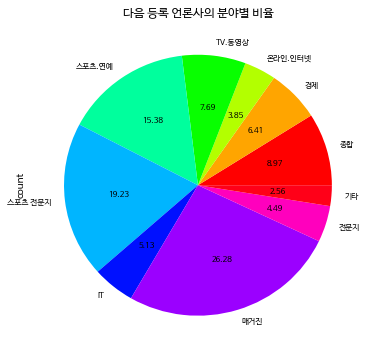

In [9]:
enrolledPress['count'].plot.pie(autopct='%.2f', colormap = plt.get_cmap('hsv'), fontsize=8, figsize=(6, 6),title='다음 등록 언론사의 분야별 비율')

### 수집기간동안 네이버 랭킹뉴스에 한건이라도 나온 언론사

In [10]:
count_by_press = df_daum.groupby('press')['id'].count().sort_values(ascending=False)
pressIn_ranked = list()
cat_press_in_ranked = dict()
for idx in count_by_press.index:
    for key in pressdict:
        if idx in pressdict[key]:
            pressIn_ranked.append(key.strip())
            cat_press_in_ranked[idx] = key.strip()
            break
pressIn_ranked = Counter(pressIn_ranked)
pressIn_ranked = pd.DataFrame.from_dict(pressIn_ranked,orient='index')
pressIn_ranked.rename(columns={0:'count_in_ranked'}, inplace = True)

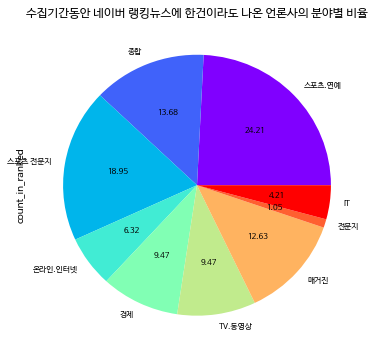

In [11]:
pressIn_ranked['count_in_ranked'].plot.pie(autopct='%.2f', fontsize=8,colormap = plt.get_cmap('rainbow'), figsize=(6, 6), title = '수집기간동안 네이버 랭킹뉴스에 한건이라도 나온 언론사의 분야별 비율')

In [12]:
total_and_ranked = pd.merge(enrolledPress, pressIn_ranked, left_index=True, right_index=True, how='outer')
total_and_ranked.fillna(0,inplace=True)
total_and_ranked['count_in_ranked'] = total_and_ranked['count_in_ranked'].astype(int)
total_and_ranked['percentage'] = total_and_ranked['count_in_ranked']/total_and_ranked['count'] * 100
total_and_ranked = total_and_ranked.sort_values(by='percentage', ascending=False)
total_and_ranked.T

,온라인.인터넷,스포츠.연예,종합,경제,TV.동영상,스포츠 전문지,IT,매거진,전문지,기타
count,6.0,24.000000,14.000000,10.0,12.0,30.0,8.0,41.000000,7.000000,4.0
count_in_ranked,6.0,23.000000,13.000000,9.0,9.0,18.0,4.0,12.000000,1.000000,0.0
percentage,100.0,95.833333,92.857143,90.0,75.0,60.0,50.0,29.268293,14.285714,0.0


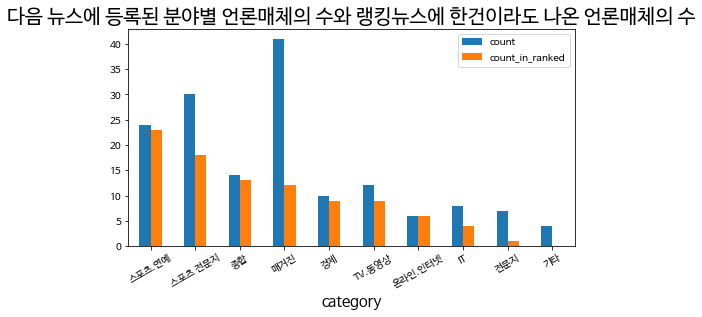

In [13]:
f1 = plt.figure(figsize=(8,4))
plt.title('다음 뉴스에 등록된 분야별 언론매체의 수와 랭킹뉴스에 한건이라도 나온 언론매체의 수', color='black',fontsize=20)
total_and_ranked[['count','count_in_ranked']].sort_values(by='count_in_ranked', ascending=False).plot(kind='bar', ax=f1.gca())
plt.xticks(fontsize=10,rotation=30)
plt.yticks(fontsize=10)
plt.xlabel('category',fontsize=15)
plt.show()

### 일별 뉴스기사수

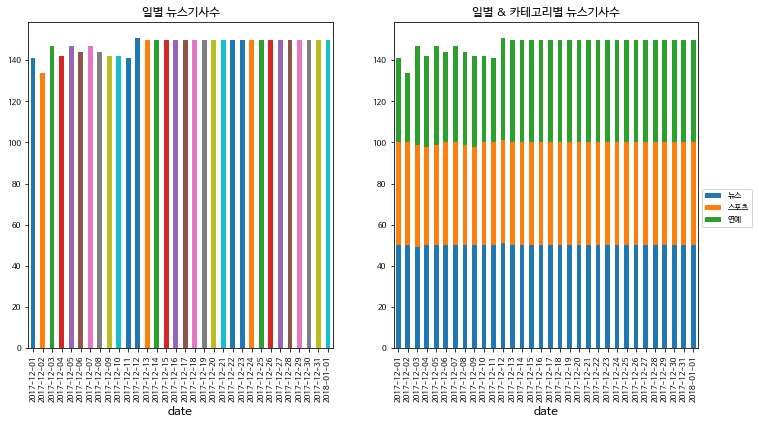

In [14]:
f1 = plt.figure(figsize=(12,6))
ax1 = f1.add_subplot(1, 2, 1)
plt.title('일별 뉴스기사수', color='black')
df_daum.groupby('date')['id'].count().plot(kind = 'bar',rot=90,ax=ax1)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
ax2 = f1.add_subplot(1, 2, 2)
plt.title('일별 & 카테고리별 뉴스기사수', color='black')
df_daum.groupby(['date','category'])['id'].count().unstack().plot(kind='bar',stacked=True,ax=ax2)
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5),fontsize=8)
plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

> * 총 4722개의 뉴스기사

### 언론사별 뉴스기사수

In [15]:
count_by_press = df_daum.groupby('press')['id'].count().sort_values(ascending=False)

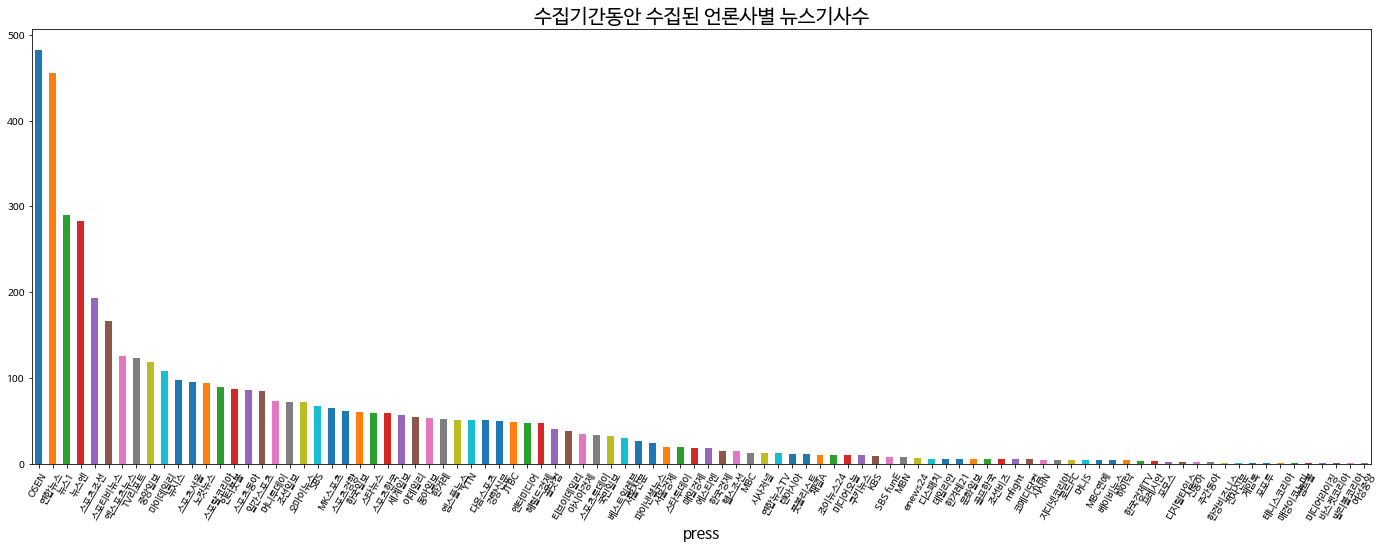

In [16]:
f1 = plt.figure(figsize=(24,8))
plt.title('수집기간동안 수집된 언론사별 뉴스기사수', color='black', fontsize= 20)
count_by_press.plot(kind='bar', rot=60,ax = f1.gca())
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('press',fontsize=15)
plt.show()

언론사 : OSEN, 분야 : 스포츠.연예
언론사 : 연합뉴스, 분야 : 종합
언론사 : 뉴스1, 분야 : 종합
언론사 : 뉴스엔, 분야 : 스포츠.연예
언론사 : 스포츠조선, 분야 : 스포츠.연예
언론사 : 스포티비뉴스, 분야 : 스포츠 전문지
언론사 : 엑스포츠뉴스, 분야 : 스포츠.연예
언론사 : TV리포트, 분야 : 스포츠.연예
언론사 : 중앙일보, 분야 : 종합
언론사 : 마이데일리, 분야 : 스포츠.연예
언론사 : 뉴시스, 분야 : 종합
언론사 : 스포츠서울, 분야 : 스포츠.연예
언론사 : 노컷뉴스, 분야 : 온라인.인터넷
언론사 : 스포탈코리아, 분야 : 스포츠 전문지
언론사 : 인터풋볼, 분야 : 스포츠 전문지
언론사 : 스포츠동아, 분야 : 스포츠.연예
언론사 : 일간스포츠, 분야 : 스포츠.연예
언론사 : 머니투데이, 분야 : 경제
언론사 : 조선일보, 분야 : 종합
언론사 : 오마이뉴스, 분야 : 온라인.인터넷
언론사 : SBS, 분야 : TV.동영상
언론사 : MK스포츠, 분야 : 스포츠.연예
언론사 : 스포츠경향, 분야 : 스포츠.연예
언론사 : 한국일보, 분야 : 종합
언론사 : 스타뉴스, 분야 : 스포츠.연예
언론사 : 스포츠한국, 분야 : 스포츠.연예
언론사 : 세계일보, 분야 : 종합
언론사 : 이데일리, 분야 : 경제
언론사 : 동아일보, 분야 : 종합
언론사 : 한겨레, 분야 : 종합
언론사 : 엠스플뉴스, 분야 : 스포츠 전문지
언론사 : YTN, 분야 : TV.동영상
언론사 : 다음스포츠, 분야 : 기타
언론사 : 경향신문, 분야 : 종합
언론사 : JTBC, 분야 : TV.동영상
언론사 : 엔터미디어, 분야 : 스포츠.연예
언론사 : 헤럴드경제, 분야 : 경제
언론사 : 골닷컴, 분야 : 스포츠 전문지
언론사 : 티브이데일리, 분야 : 스포츠.연예
언론사 : 아시아경제, 분야 : 경제
언론사 : 스포츠투데이, 분야 : 스포츠.연예
언론사 : 국민일보, 분야 : 종합
언론사 : 베스트일레븐, 분야 : 스포츠 전문지
언론사

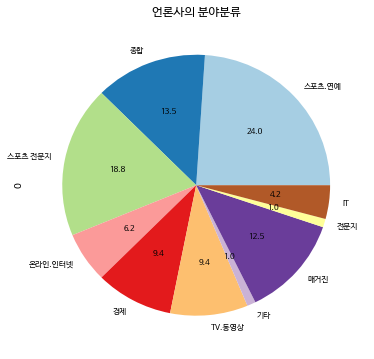

In [17]:
catis = list()
for idx in count_by_press.index:
    if idx in cat_press_in_ranked:
        catis.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        catis.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
catis = pd.DataFrame.from_dict(Counter(catis), orient='index')[0]
catis.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

* 위의 목록에 존재하지 않는 언론사는 기타로 분류

In [18]:
print ('수집기간동안 상위 3위인 언론사의 뉴스기사 비율 : {:0.2f}'.format(count_by_press[:3].sum()/count_by_press.sum()))

수집기간동안 상위 3위인 언론사의 뉴스기사 비율 : 0.26


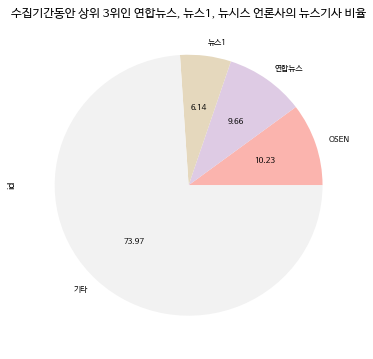

In [19]:
top3 = count_by_press[:3]
top3['기타'] = count_by_press.sum()-count_by_press[:3].sum()
top3.plot.pie(autopct='%.2f', fontsize=8, figsize=(6, 6),colormap = plt.get_cmap('Pastel1'), title = '수집기간동안 상위 3위인 연합뉴스, 뉴스1, 뉴시스 언론사의 뉴스기사 비율')

언론사 : OSEN, 분야 : 스포츠.연예
언론사 : 연합뉴스, 분야 : 종합
언론사 : 뉴스1, 분야 : 종합


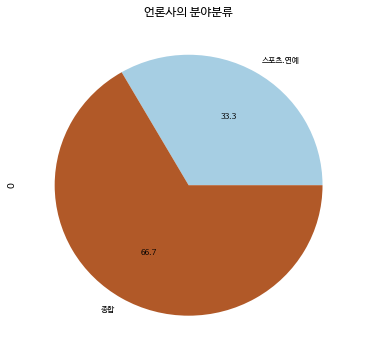

In [20]:
top3cat = list()
for idx in count_by_press[:3].index:
    print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))
    top3cat.append(cat_press_in_ranked[idx])
top3cat = pd.DataFrame.from_dict(Counter(top3cat), orient='index')[0]
top3cat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

#### 뉴스기사수가 상위 10위내 언론사에 대하여 알아보자

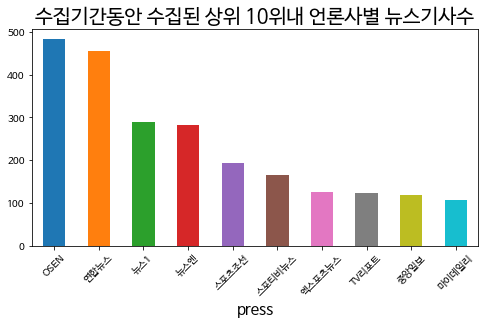

In [21]:
f1 = plt.figure(figsize=(8,4))
plt.title('수집기간동안 수집된 상위 10위내 언론사별 뉴스기사수', color='black', fontsize= 20)
count_by_press[:10].plot(kind='bar', rot=45,ax = f1.gca())
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('press',fontsize=15)
plt.show()

In [22]:
print ('수집기간동안 상위 10위이내 언론사의 뉴스기사 비율 : {:0.2f}'.format(count_by_press[:10].sum()/count_by_press.sum()))

수집기간동안 상위 10위이내 언론사의 뉴스기사 비율 : 0.50


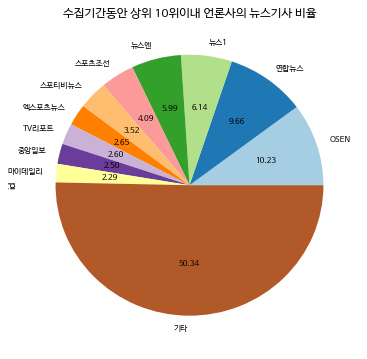

In [23]:
top10 = count_by_press[:10]
top10['기타'] = count_by_press.sum()-count_by_press[:10].sum()
top10.plot.pie(autopct='%.2f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title = '수집기간동안 상위 10위이내 언론사의 뉴스기사 비율')

언론사 : OSEN, 분야 : 스포츠.연예
언론사 : 연합뉴스, 분야 : 종합
언론사 : 뉴스1, 분야 : 종합
언론사 : 뉴스엔, 분야 : 스포츠.연예
언론사 : 스포츠조선, 분야 : 스포츠.연예
언론사 : 스포티비뉴스, 분야 : 스포츠 전문지
언론사 : 엑스포츠뉴스, 분야 : 스포츠.연예
언론사 : TV리포트, 분야 : 스포츠.연예
언론사 : 중앙일보, 분야 : 종합
언론사 : 마이데일리, 분야 : 스포츠.연예


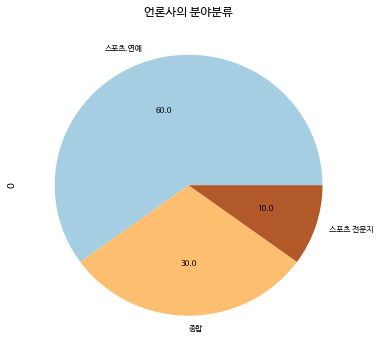

In [24]:
top10cat = list()
for idx in count_by_press[:10].index:
    print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))
    top10cat.append(cat_press_in_ranked[idx])
top10cat = pd.DataFrame.from_dict(Counter(top10cat), orient='index')[0]
top10cat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6),title='언론사의 분야분류')

#### 뉴스기사수가 상위 20위내 언론사에 대하여 알아보자

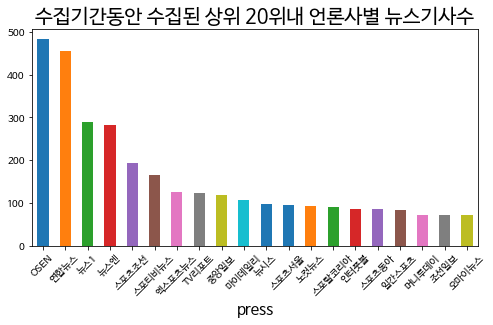

In [25]:
f1 = plt.figure(figsize=(8,4))
plt.title('수집기간동안 수집된 상위 20위내 언론사별 뉴스기사수', color='black', fontsize= 20)
count_by_press[:20].plot(kind='bar', rot=45,ax = f1.gca())
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('press',fontsize=15)
plt.show()

In [26]:
print ('수집기간동안 상위 20위이내 언론사의 뉴스기사 비율 : {:0.2f}'.format(count_by_press[:20].sum()/count_by_press.sum()))

수집기간동안 상위 20위이내 언론사의 뉴스기사 비율 : 0.68


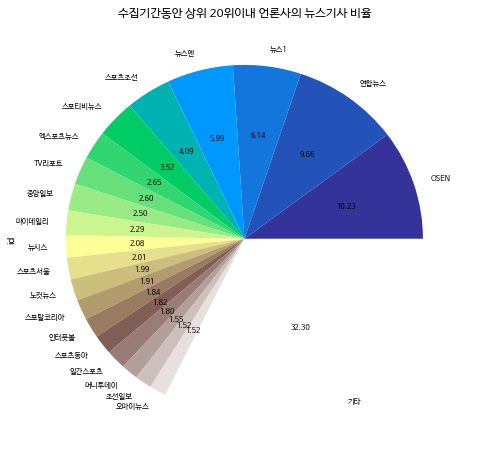

In [27]:
top20 = count_by_press[:20]
top20['기타'] = count_by_press.sum()-count_by_press[:20].sum()
top20.plot.pie(autopct='%.2f', fontsize=7.5, figsize=(8, 8),colormap = plt.get_cmap('terrain'), title = '수집기간동안 상위 20위이내 언론사의 뉴스기사 비율')

언론사 : OSEN, 분야 : 스포츠.연예
언론사 : 연합뉴스, 분야 : 종합
언론사 : 뉴스1, 분야 : 종합
언론사 : 뉴스엔, 분야 : 스포츠.연예
언론사 : 스포츠조선, 분야 : 스포츠.연예
언론사 : 스포티비뉴스, 분야 : 스포츠 전문지
언론사 : 엑스포츠뉴스, 분야 : 스포츠.연예
언론사 : TV리포트, 분야 : 스포츠.연예
언론사 : 중앙일보, 분야 : 종합
언론사 : 마이데일리, 분야 : 스포츠.연예
언론사 : 뉴시스, 분야 : 종합
언론사 : 스포츠서울, 분야 : 스포츠.연예
언론사 : 노컷뉴스, 분야 : 온라인.인터넷
언론사 : 스포탈코리아, 분야 : 스포츠 전문지
언론사 : 인터풋볼, 분야 : 스포츠 전문지
언론사 : 스포츠동아, 분야 : 스포츠.연예
언론사 : 일간스포츠, 분야 : 스포츠.연예
언론사 : 머니투데이, 분야 : 경제
언론사 : 조선일보, 분야 : 종합
언론사 : 오마이뉴스, 분야 : 온라인.인터넷


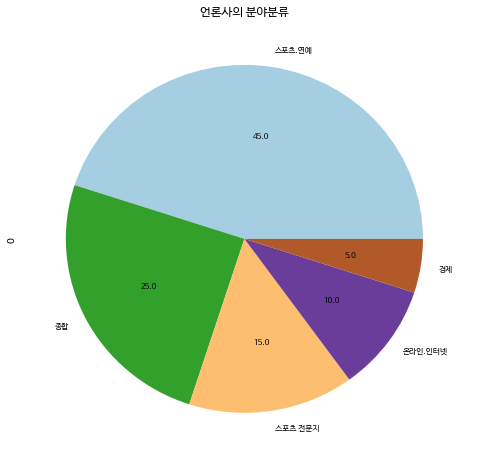

In [28]:
top20cat = list()
for idx in count_by_press[:20].index:
    print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))
    top20cat.append(cat_press_in_ranked[idx])
top20cat = pd.DataFrame.from_dict(Counter(top20cat), orient='index')[0]
top20cat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(8, 8),title='언론사의 분야분류')

### 일별 & 언론별 뉴스기사수

In [29]:
date_press_daum = df_daum.groupby(['date','press'])['id'].count()

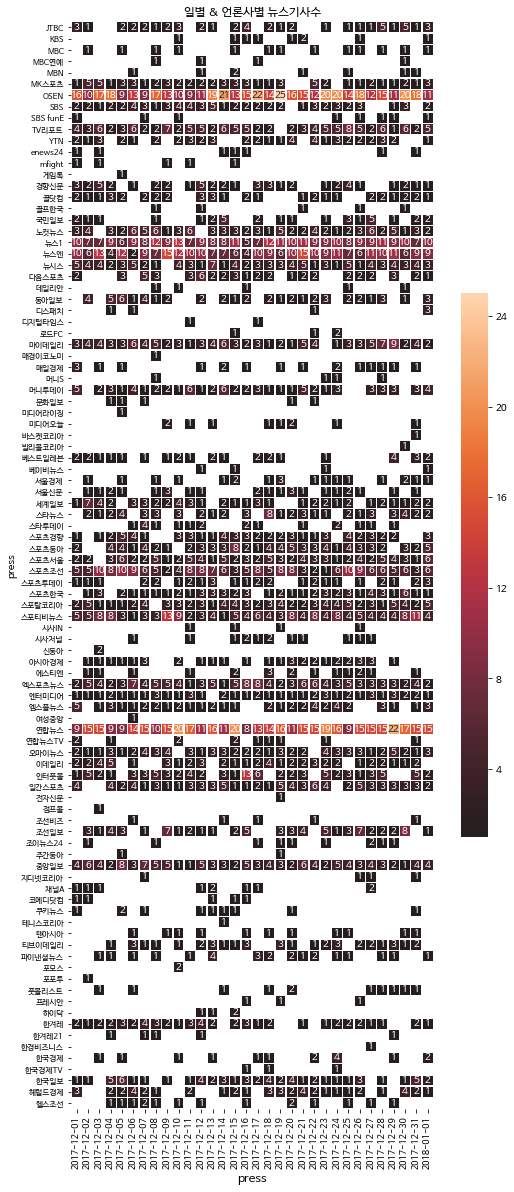

In [30]:
f1 = plt.figure(figsize=(10,20))
plt.title('일별 & 언론사별 뉴스기사수', color='black')
sns.heatmap(date_press_daum.unstack().T, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=f1.gca())
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('press',fontsize=12)
plt.show()

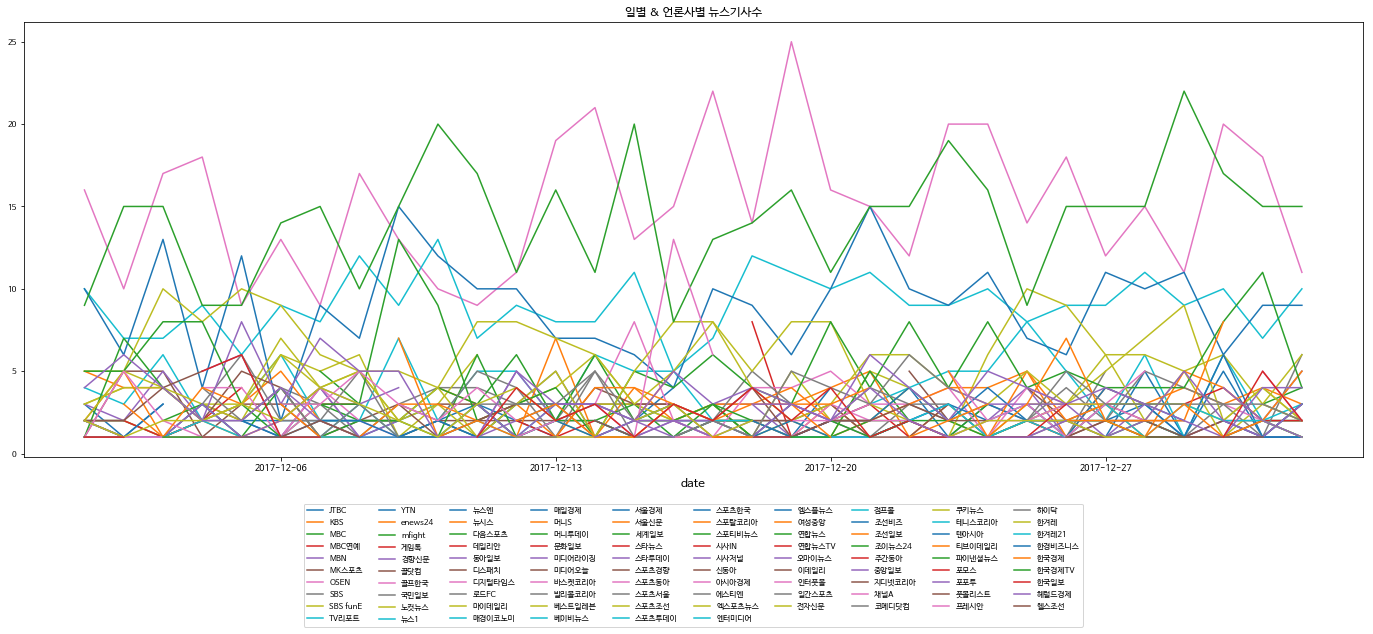

In [31]:
f1 = plt.figure(figsize=(24,8))
plt.title('일별 & 언론사별 뉴스기사수', color='black')
date_press_daum.unstack().plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.4),ncol = 10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

#### * 뉴스 수집기간동안 매일 최소 한건의 기사가 랭킹뉴스에 등록된 언론사

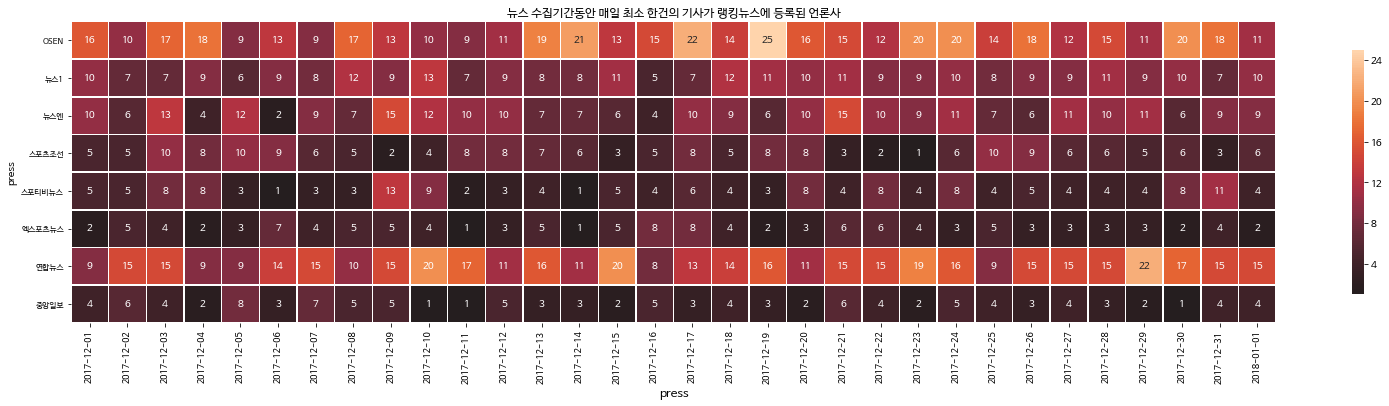

In [32]:
f1 = plt.figure(figsize=(27,9))
plt.title('뉴스 수집기간동안 매일 최소 한건의 기사가 랭킹뉴스에 등록된 언론사', color='black')
sns.heatmap(date_press_daum.unstack().dropna(axis = 1).T, center=0, annot=True,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, ax=f1.gca())
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('press',fontsize=12)
plt.show()

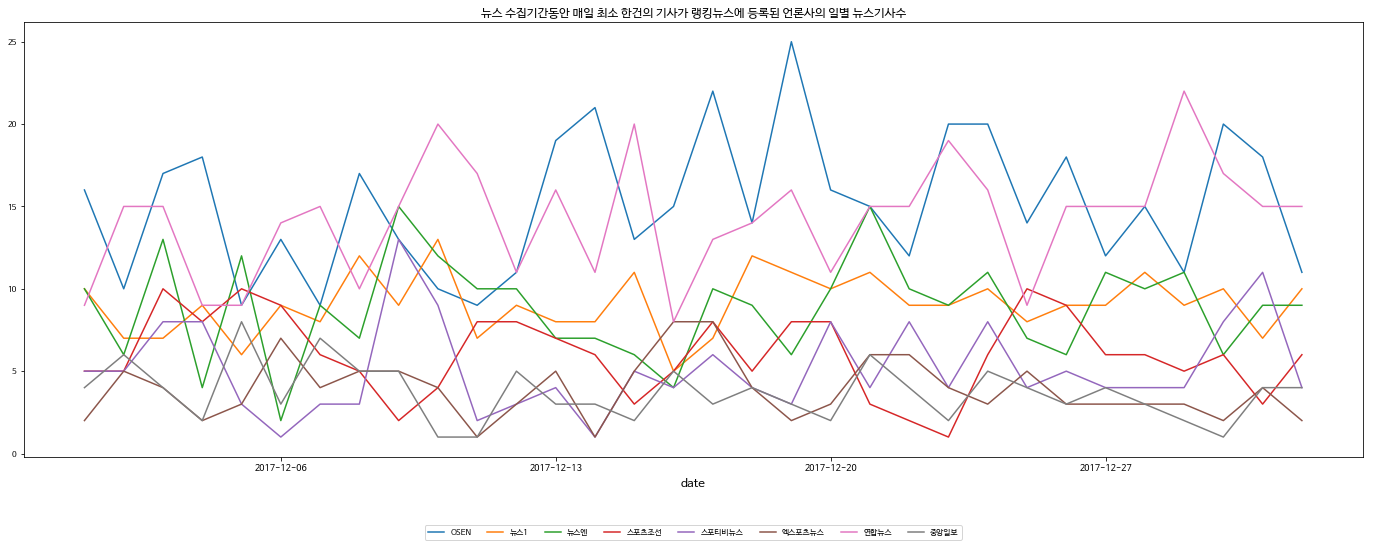

In [33]:
f1 = plt.figure(figsize=(24,8))
plt.title('뉴스 수집기간동안 매일 최소 한건의 기사가 랭킹뉴스에 등록된 언론사의 일별 뉴스기사수', color='black')
date_press_daum.unstack().dropna(axis = 1).plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=9)
plt.yticks(fontsize=8)
plt.xlabel('date',fontsize=12)
plt.show()

언론사 : OSEN, 분야 : 스포츠.연예
언론사 : 뉴스1, 분야 : 종합
언론사 : 뉴스엔, 분야 : 스포츠.연예
언론사 : 스포츠조선, 분야 : 스포츠.연예
언론사 : 스포티비뉴스, 분야 : 스포츠 전문지
언론사 : 엑스포츠뉴스, 분야 : 스포츠.연예
언론사 : 연합뉴스, 분야 : 종합
언론사 : 중앙일보, 분야 : 종합


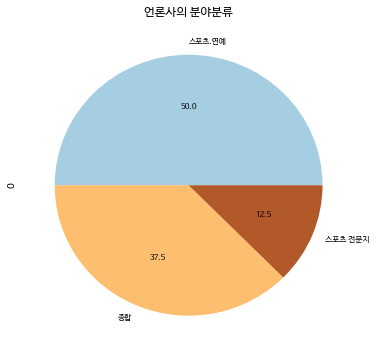

In [34]:
alldaysCat = list()
for idx in date_press_daum.unstack().dropna(axis = 1).columns:
    if idx in cat_press_in_ranked:
        alldaysCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        alldaysCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
alldaysCat = pd.DataFrame.from_dict(Counter(alldaysCat), orient='index')[0]
alldaysCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

#### 뉴스량 상위 3, 상위 10, 상위 20 개 언론사를 대상으로 그래프를 그려보자

In [35]:
total_3_press = date_press_daum.unstack().sum(axis = 0).sort_values(ascending=False)[:3].index
total_10_press = date_press_daum.unstack().sum(axis = 0).sort_values(ascending=False)[:10].index
total_20_press = date_press_daum.unstack().sum(axis = 0).sort_values(ascending=False)[:20].index

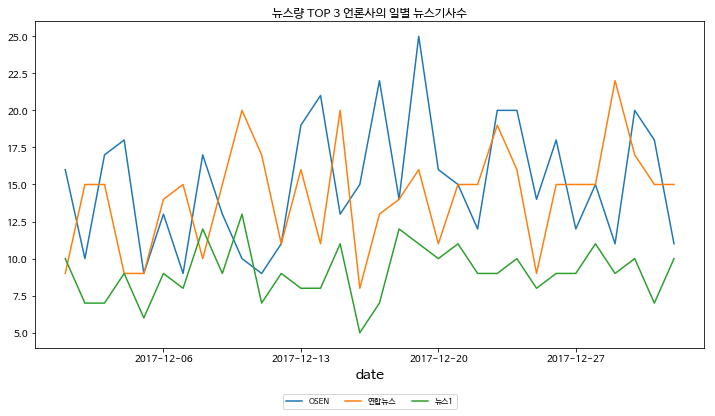

In [36]:
f1 = plt.figure(figsize=(12,6))
plt.title('뉴스량 TOP 3 언론사의 일별 뉴스기사수', color='black')
date_press_daum.unstack().loc[:,total_3_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

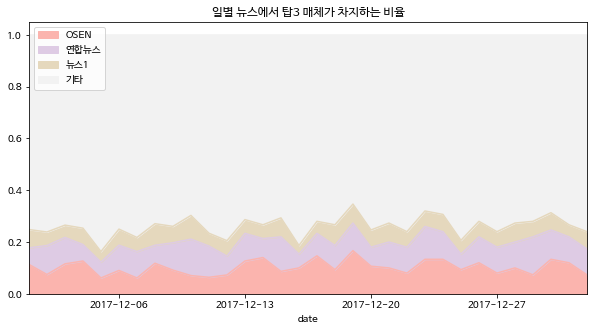

In [37]:
t3p = date_press_daum.unstack().loc[:,total_3_press]
t3p['기타'] = date_press_daum.unstack().sum(axis = 1 ) - t3p.sum(axis = 1)
t3p = t3p.divide(t3p.sum(axis=1), axis=0)
t3p.plot(kind='area',colormap = plt.get_cmap('Pastel1'),figsize=(10,5))
plt.legend(loc='upper left')
plt.margins(0,0)
plt.title('일별 뉴스에서 탑3 매체가 차지하는 비율')
plt.show()

NameError: name 'date_press_naver' is not defined

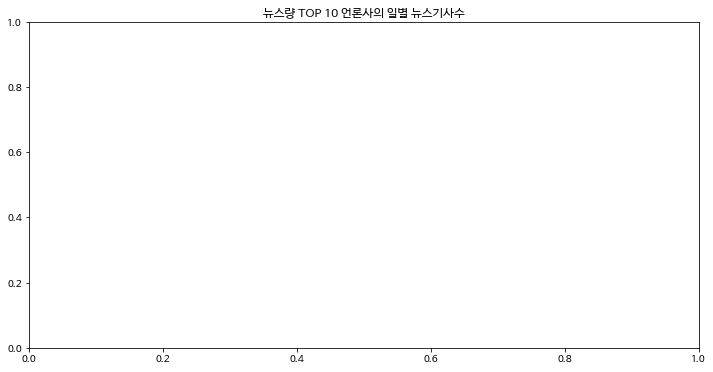

In [38]:
f1 = plt.figure(figsize=(12,6))
plt.title('뉴스량 TOP 10 언론사의 일별 뉴스기사수', color='black')
date_press_naver.unstack().loc[:,total_10_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

In [ ]:
t10p = date_press_daum.unstack().loc[:,total_10_press]
t10p['기타'] = date_press_daum.unstack().sum(axis = 1 ) - t10p.sum(axis = 1)
t10p = t10p.divide(t10p.sum(axis=1), axis=0)
t10p.plot(kind='area',colormap = plt.get_cmap('Paired'),figsize=(10,5))
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4),ncol = 10)
plt.margins(0,0)
plt.title('일별 뉴스에서 탑10 매체가 차지하는 비율')
plt.show()

In [ ]:
f1 = plt.figure(figsize=(12,6))
plt.title('뉴스량 TOP 20 언론사의 일별 뉴스기사수', color='black')
date_press_daum.unstack().loc[:,total_20_press].plot(kind='line',ax=f1.gca())
plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.2),ncol = 10)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel('date',fontsize=14)
plt.show()

In [ ]:
t20p = date_press_daum.unstack().loc[:,total_20_press]
t20p['기타'] = date_press_daum.unstack().sum(axis = 1 ) - t20p.sum(axis = 1)
t20p = t20p.divide(t20p.sum(axis=1), axis=0)
t20p.plot(kind='area',colormap = plt.get_cmap('terrain'),figsize=(10,5))
plt.legend(loc='lower center', bbox_to_anchor=(0.5,-0.4),ncol = 10)
plt.margins(0,0)
plt.title('일별 뉴스에서 탑20 매체가 차지하는 비율')
plt.show()

* 상위 20위까지 언론매체가 일별로 점유율이 평균적으로 0.6 이상인 것으로 판단됨

### 카테고리별 & 언론사별 뉴스기사

In [ ]:
category_press_daum = df_daum.groupby(['category','press'])['id'].count()

In [ ]:
sortedcpn = category_press_daum.unstack().loc[:,date_press_daum.unstack().sum(axis = 0).sort_values(ascending=False).index]

In [ ]:
f1 = plt.figure(figsize=(80,10))
plt.title('카테고리 & 언론사별 뉴스기사수', color='black',fontsize=30)
sns.heatmap(sortedcpn, center=0, annot=True, fmt='.0f',annot_kws={"size": 17.5},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('press',fontsize=25)
plt.ylabel('category',fontsize=25)
plt.show()

In [ ]:
f1 = plt.figure(figsize=(80,10))
plt.title('특정 카테고리에서의 해당 언론사의 뉴스기사 비율', color='black',fontsize=30)
sns.heatmap(sortedcpn.fillna(0).divide(sortedcpn.sum(axis = 1),axis = 0), center=0, annot=True, fmt='.2f',annot_kws={"size": 12},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.xlabel('press',fontsize=25)
plt.ylabel('category',fontsize=25)
plt.show()

#### * 모든 카테고리(정치, 연예, 스포츠, 세계, 생활/문화, 사회, 경제, IT/과학)에 뉴스 기사가 최소 하나가 있는 언론매체

In [ ]:
allCatPress = sortedcpn.dropna(axis = 1)
f1 = plt.figure(figsize=(16,8))
plt.title('모든 카테고리에 뉴스 기사가 최소 하나가 있는 언론매체의 일별 뉴스기사수', color='black',fontsize=25)
sns.heatmap(allCatPress, center=0, annot=True, fmt='.0f',annot_kws={"size": 17.5},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=14,rotation=45)
plt.yticks(fontsize=14,rotation=0)
plt.xlabel('press',fontsize=17)
plt.ylabel('category',fontsize=17)
plt.show()

In [ ]:
allCat = list()
for idx in allCatPress.columns:
    if idx in cat_press_in_ranked:
        allCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        allCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
allCat = pd.DataFrame.from_dict(Counter(allCat), orient='index')[0]
allCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

#### * 모든 카테고리중에서 특정 카테고리에만 뉴스기사가 최소 1개가 나오는 언론매체

In [ ]:
pressList = list()
for idx in sortedcpn.columns:
    x = sortedcpn.loc[:,idx]
    if x.isna().sum() == 2:
        pressList.append(idx)
print (len(pressList))

In [ ]:
f1 = plt.figure(figsize=(20,8))
plt.title('특정 카테고리에만 뉴스 기사가 나오는 언론매체의 뉴스기사수', color='black',fontsize=25)
sns.heatmap(sortedcpn.loc[:,pressList], center=0, annot=True, fmt='.0f',annot_kws={"size": 17.5},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=17)
plt.yticks(fontsize=17,rotation=0)
plt.xlabel('press',fontsize=15)
plt.ylabel('category',fontsize=15)
plt.show()

In [ ]:
specificCat = list()
for idx in pressList:
    if idx in cat_press_in_ranked:
        specificCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        specificCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
specificCat = pd.DataFrame.from_dict(Counter(specificCat), orient='index')[0]
specificCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

#### * 연예 & 스포츠에 특화된 언론매체

In [ ]:
sePress = sortedcpn.loc[:,sortedcpn.loc[['스포츠','연예'],:].sum()!=0]
fis= sePress.loc[:,sePress.loc[sePress.index.difference(['스포츠','연예']),:].sum(axis = 0) <=1]
fis.columns

In [ ]:
f1 = plt.figure(figsize=(24,8))
plt.title('연예, 스포츠 특화 매체로 판단되는 언론매체의 뉴스기사수', color='black',fontsize=17)
sns.heatmap(sortedcpn.loc[:,fis.columns], center=0, annot=True, fmt='.0f',annot_kws={"size": 12},
            linewidths=.25, cbar_kws={"shrink": 1}, ax=f1.gca())
plt.xticks(fontsize=13)
plt.yticks(fontsize=13,rotation=0)
plt.xlabel('press',fontsize=15)
plt.ylabel('category',fontsize=15)
plt.show()

In [ ]:
esCat = list()
for idx in fis.columns:
    if idx in cat_press_in_ranked:
        esCat.append(cat_press_in_ranked[idx])
        print ('언론사 : {}, 분야 : {}'.format(idx, cat_press_in_ranked[idx]))    
    else:
        esCat.append('기타')
        print ('언론사 : {}, 분야 : {}'.format(idx, '기타'))    
esCat = pd.DataFrame.from_dict(Counter(esCat), orient='index')[0]
esCat.plot.pie(autopct='%.1f',colormap = plt.get_cmap('Paired'), fontsize=8, figsize=(6, 6), title='언론사의 분야분류')

### 카테고리별로 일별 & 언론사별 뉴스기사

In [39]:
date_category_daum = df_daum.groupby(['category','date','press']).count()['id'].unstack()

#### 카테고리별로 전체가 NaN값인 것은 제외

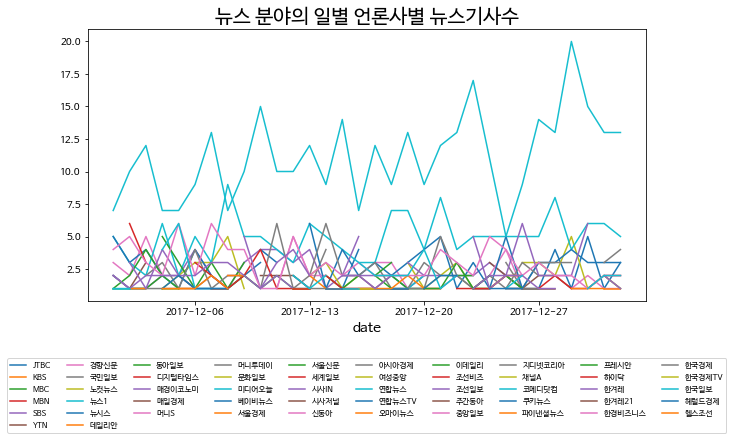

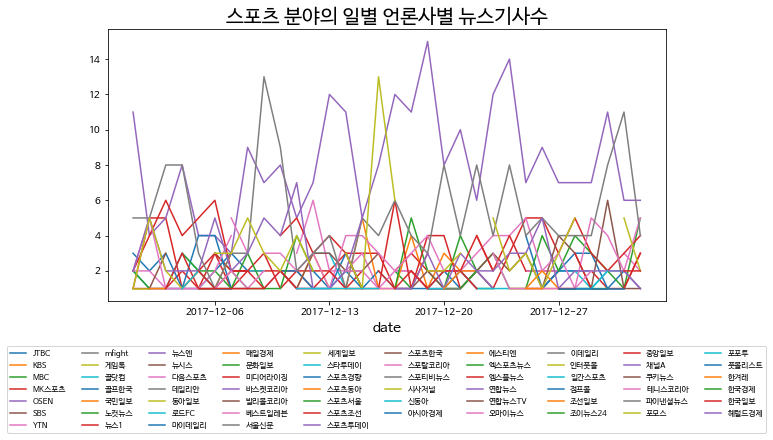

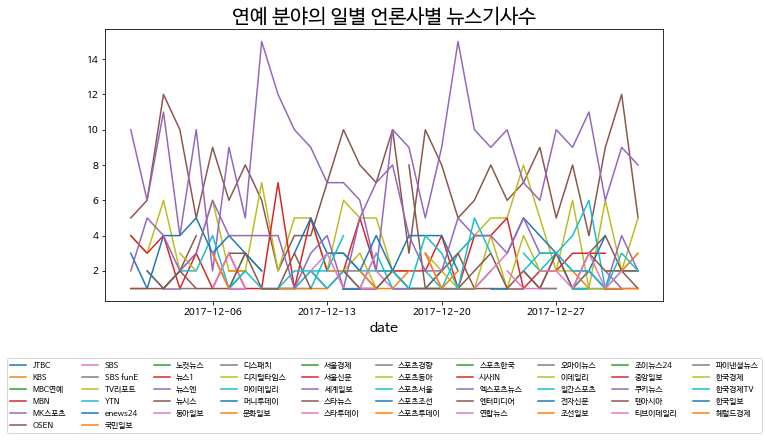

In [40]:
for idx in date_category_daum.index.levels[0]:
    f1 = plt.figure(figsize=(10,5))
    plt.title('{} 분야의 일별 언론사별 뉴스기사수'.format(idx), color='black', fontsize = 20)
    d = date_category_daum.loc[idx,:]
    d.dropna(axis = 1,thresh=1,inplace=True)
    d.plot(kind='line',ax=f1.gca())
    plt.legend(loc='lower center',fontsize=8, bbox_to_anchor=(0.5,-0.5),ncol = 10)
    plt.xticks(fontsize=10)
    plt.yticks(fontsize=10)
    plt.xlabel('date',fontsize=14)
    plt.show()

## 키워드 분석

In [41]:
def LoadFromPickle(filelist):
    outdict = dict()
    for file in filelist:
        outdict.update(pickle.load(open(file,'rb')))
    return outdict

In [42]:
keywordsData = LoadFromPickle(glob('./data/pre_data/keywords_daum.pickled*'))

In [43]:
df_daum = df_daum.sort_values(by=['date','category'])

In [44]:
keywordDict = dict()
for idx in df_daum.index:
    idis = df_daum.loc[idx,'id']
    date = df_daum.loc[idx, 'date']
    category= df_daum.loc[idx, 'category']
    if not category in keywordDict:
        keywordDict[category] = list()
    outlist = keywordDict[category]
    outlist.extend(keywordsData[idis])

In [45]:
from wordcloud import WordCloud
import pytagcloud

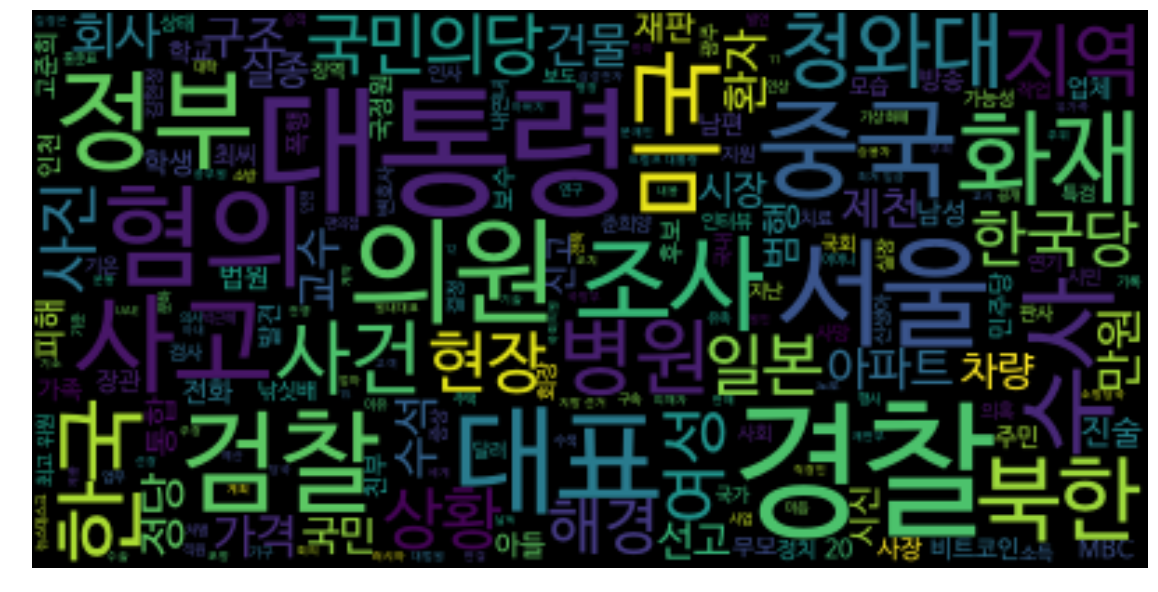

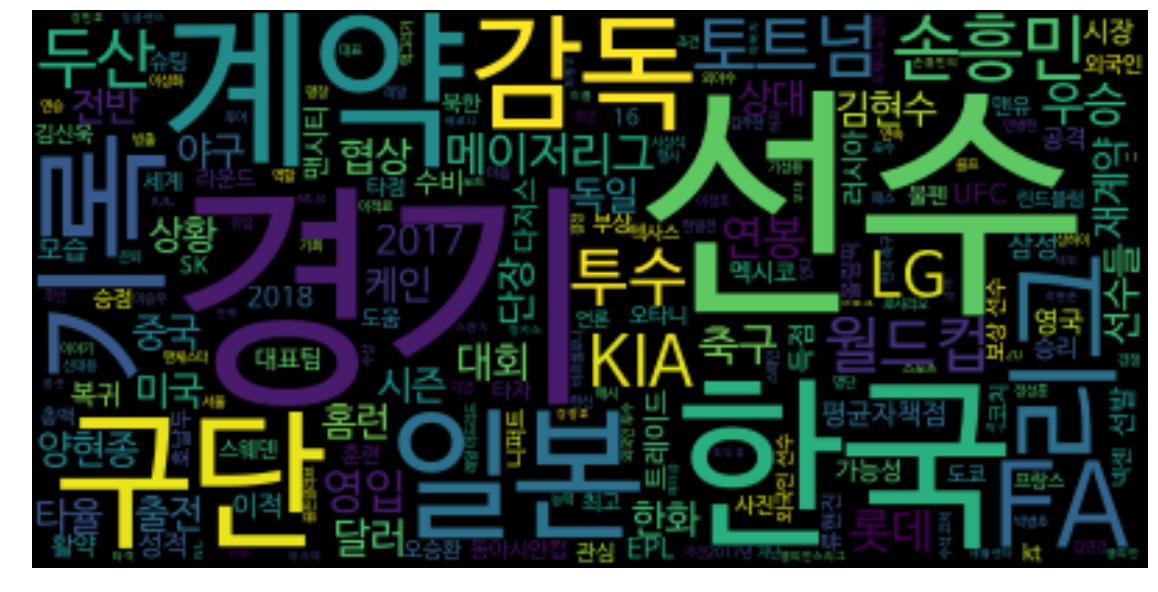

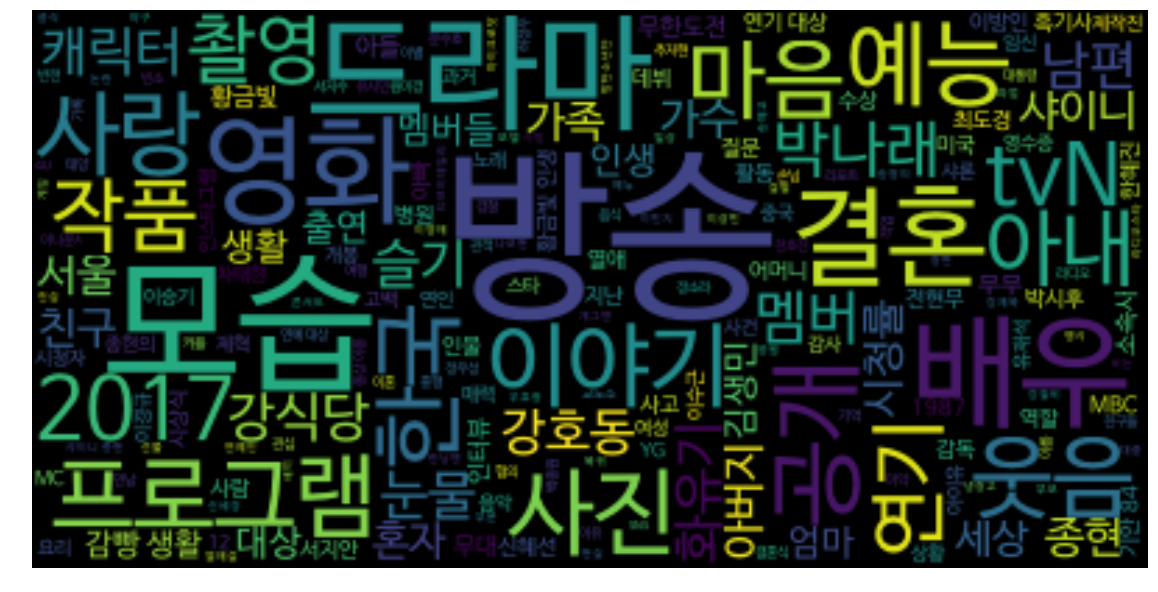

In [ ]:
for i in keywordDict:
    x =keywordDict[i]
    x1 = WordCloud(font_path='/Library/Fonts/NanumBarunGothic.otf').generate_from_frequencies(Counter(x))
    plt.figure(figsize=(20,20))
    plt.imshow(x1, interpolation='bilinear')
    plt.axis('off')
    plt.show()

In [ ]:
for i in keywordDict:
    x =keywordDict[i]
    count = Counter(x)
    taglist = pytagcloud.make_tags(count.most_common(), maxsize=50)
    pytagcloud.create_tag_image(taglist, 'wordcloud.jpg', size=(900, 600), fontname='Korean', rectangular=False)

## 댓글 분석

### 요일별 정리

In [ ]:
commentsCollection = dh.Use_Collection(useDb, 'comments')

In [ ]:
group_by_date = df_daum.groupby('date')['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(12,4))
plt.title('요일별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
group_by_date.mean().plot(kind='line', ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

* 등록된 댓글수와 실제 크롤링된 댓글수가 차이를 보이는 것은 작성자가 삭제하였거나, 스팸신고, 타 사용자의 신고로 삭제된 댓글이 존재하기 때문임

### 요일별 & 카테고리별 정리

In [ ]:
group_by_date_category = df_daum.groupby(['date', 'category'])['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(16,4))
plt.title('요일별 카테고리별 평균 댓글수', color='black')
group_by_date_category.mean()['number_of_comment'].unstack().plot(ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
f = plt.figure(figsize=(16,4))
plt.title('요일별 카테고리별 평균 크롤링된 댓글수', color='black')
group_by_date_category.mean()['number_of_crawled_comment'].unstack().plot(kind='line', ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

### 카테고리별 정리

In [ ]:
group_by_category = df_daum.groupby('category')['number_of_comment', 'number_of_crawled_comment']

In [ ]:
f = plt.figure(figsize=(6,4))
plt.title('카테고리별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
group_by_category.mean().plot.barh( ax=f.gca())
plt.legend(loc='best', bbox_to_anchor=(1.0, 0.5))
plt.show()

In [ ]:
fDf = df_daum[['category','number_of_comment', 'number_of_crawled_comment']]

In [ ]:
f = plt.figure(figsize=(8,10))
plt.title('카테고리별 평균 댓글수와 평균 크롤링된 댓글수', color='black')
dd = pd.melt(fDf, id_vars = ['category'], value_vars=['number_of_comment', 'number_of_crawled_comment'],var_name='x')
sns.boxplot(x = 'category', y = 'value', data =dd, hue = 'x', ax=f.gca())
plt.show()